In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.sql import and_, or_

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [7]:
station_c = inspector.get_columns('station')
for c in station_c:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
measure_c = inspector.get_columns('measurement')
for c in measure_c:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [15]:
# Calculate the date one year from the last date in data set.
one_year = session.query(Measurement.date).filter(Measurement.date > '2016-08-23')

year_ago = dt.datetime(2017, 8, 23)-dt.timedelta(days=365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

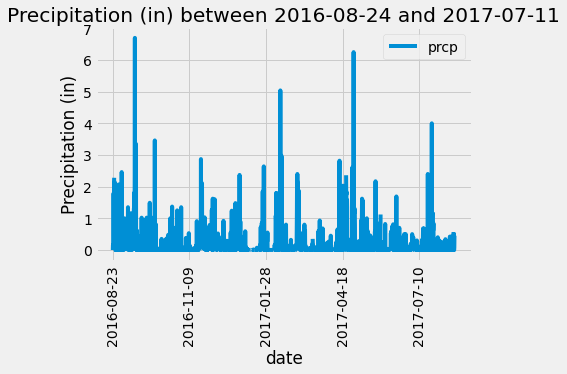

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 



# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date.label('date'),
      Measurement.prcp.label('prcp')]

one_year_precip = session.query(*sel).filter(and_(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-24')).\
order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_measurement = pd.DataFrame(one_year_precip, columns = ['date', 'prcp'])
#prcp_measurement.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_measurement.sort_values(by ='date')
# date = prcp_measurement['date']
# preciptitation = prcp_measurement['prcp']


# Use Pandas Plotting with Matplotlib to plot the data
prcp_measurement.plot(x='date', y='prcp', rot=90);
plt.ylabel('Precipitation (in)');
plt.title("Precipitation (in) between 2016-08-24 and 2017-07-11");

In [19]:
plt.savefig("year_precip_data.png")

<Figure size 432x288 with 0 Axes>

In [16]:

prcp_measurement['prcp'].max()

6.7

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_measurement['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [163]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, 
      func.max(Measurement.tobs).label('max_temp'),
      func.min(Measurement.tobs).label("min_temp"),
      func.avg(Measurement.tobs).label('avg_temp')]

session.query(*sel).\
filter(and_(Measurement.station == 'USC00519281')).all()

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_recent = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(and_(Measurement.station == 'USC00519281')).order_by(Measurement.date.desc()).first()
station_recent

('USC00519281', '2017-08-18', 79.0)

In [27]:
sel = [Measurement.station.label('station'),
       Measurement.date.label('date'),
       Measurement.tobs.label('tobs')
      ]

station_year_prcp = session.query(*sel).filter(and_(Measurement.date > '2016-08-23', Measurement.date < '2017-08-24', Measurement.station == 'USC00519281')).\
order_by(Measurement.date).all()

station_measurement = pd.DataFrame(station_year_prcp, columns = ['station','date', 'tobs'])
station_measurement

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0
...,...,...,...
346,USC00519281,2017-08-14,77.0
347,USC00519281,2017-08-15,77.0
348,USC00519281,2017-08-16,76.0
349,USC00519281,2017-08-17,76.0


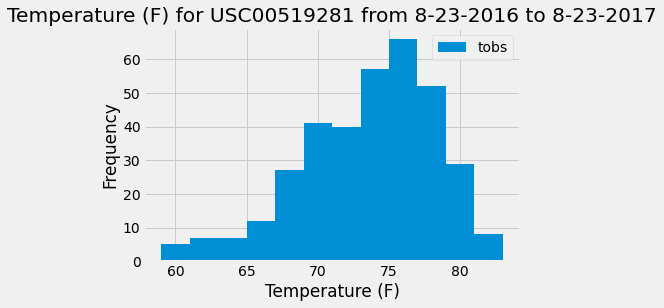

In [28]:
station_measurement.plot.hist(bins=12);
plt.xlabel("Temperature (F)");
plt.title("Temperature (F) for USC00519281 from 8-23-2016 to 8-23-2017");

# Close session

In [29]:
# Close Session
session.close()